# Calculate distances between endocardial cells and myeloid cells

In [19]:
# A function that takes as input a geojson file path, a cell table with cell annotations and two cell types of interest. It first subset the first cell type based on the geojson annotation and calculates the distances between the two cell types 
def calculate_distances(geojson_path, pixie_cell_table, sampleID, cell_type_1, cell_type_2,resolution = 0.23, n_neighbours = 3):
    import geopandas as gpd
    import pandas as pd
    from shapely.geometry import Point
    from scipy.spatial import distance
    import numpy as np
    
    # Step 1: Read GeoJSON file
    polygons_gdf = gpd.read_file(geojson_path)

    # Filter polygons_gdf for classification name = subMI_endocardiallayer
    ## Check if sampleID contains 'control'
    if 'control' in sampleID:
        subset_rows = [polygons_gdf['classification'][i]['name'] == 'Endocardial_layer' for i in range(polygons_gdf.shape[0])]
        # Subset rows of polygons_gdf by subset_rows
        polygons_gdf = polygons_gdf[subset_rows]
    else:
        subset_rows = [polygons_gdf['classification'][i]['name'] == 'subMI_endocardiallayer' for i in range(polygons_gdf.shape[0])]
        # Subset rows of polygons_gdf by subset_rows
        polygons_gdf = polygons_gdf[subset_rows]

    # Ensure polygons_gdf is using a geometry column
    if not polygons_gdf.geometry.is_valid.all():
        raise ValueError("GeoJSON contains invalid geometries.")

    # Ensure that 'x' and 'y' columns exist
    if 'X_centroid' not in pixie_cell_table.columns or 'Y_centroid' not in pixie_cell_table.columns:
        raise ValueError("Table must contain 'x' and 'y' columns.")

    # Subset pixie_cell_table for fov == Control_12
    pixie_cell_table_sub = pixie_cell_table.loc[pixie_cell_table['fov'] == sampleID]

    sample_table = pixie_cell_table_sub[pixie_cell_table_sub['cell_meta_cluster'] != 'out_of_mask']

    cells1 = pixie_cell_table_sub[pixie_cell_table_sub['cell_meta_cluster'] == cell_type_1]

    # Subset sample table for only rows where column cell_meta_cluster is equal to 'Mono / Macros Ccr2+' or 'Neutrophils' or 'Macrophages Trem2+' or 'Macrophages Trem2-'
    cells2 = pixie_cell_table_sub[pixie_cell_table_sub['cell_meta_cluster'].isin(cell_type_2) ]

    # Step 3: Convert table to GeoDataFrame
    # Assuming the table has columns 'x' and 'y' for coordinates
    geometry = [Point(xy) for xy in zip(cells1.X_centroid, cells1.Y_centroid)]

    # Ensure that the 'geometry' column contains valid Shapely Geometry objects
    if not all(isinstance(geom, Point) for geom in geometry):
        raise ValueError("Invalid geometry objects in the 'geometry' column.")

    ## Turn pixie_cell_table into a geopandas dataframe
    points_gdf = gpd.GeoDataFrame(cells1, geometry=geometry)

    # Check and set CRS
    # Assuming your polygons_gdf has a defined CRS,
    # and your points should be in the same CRS
    if polygons_gdf.crs is not None and points_gdf.crs is None:
        points_gdf.set_crs(polygons_gdf.crs, inplace=True)

    # Step 4: Spatial join
    # Perform spatial join between points and polygons
    # This will add a column 'poly_id' to points_gdf
    # which contains the index of the polygon in polygons_gdf
    
    # There are multiple polygons in polygons_gdf. Check overlap with all of them for each cell. Each cell can only be within one polygon at a time.
    points_gdf = gpd.sjoin(points_gdf, polygons_gdf, how="inner", op="within")
    
    # Step 5: Calculate distances
    ## Generate a numpy array with x and y coordinates from endocard_cells
    cells1_coords = points_gdf[['X_centroid', 'Y_centroid']].to_numpy()
    cells2_coords = cells2[['X_centroid', 'Y_centroid']].to_numpy()

    ## Step 5: Calculate distance between endocardial cells and myeloid cells
    cells_distances = distance.cdist(cells1_coords, cells2_coords, 'euclidean')

    # Transform the distances from pixel into micrometer by multiplying with the resolution of the image
    cells_distances = cells_distances * resolution

    # For each row in endo_distances, keep only the X smallest values and remove the other values from the array
    cells_distances = np.array([np.sort(row)[:n_neighbours] for row in cells_distances])

    # Flatten the array
    cells_distances = cells_distances.flatten()

    return cells_distances

<>:97: SyntaxWarning: invalid escape sequence '\m'
<>:97: SyntaxWarning: invalid escape sequence '\m'
/var/folders/ph/m6mhj3s541799cykzbp3dx0m0000gn/T/ipykernel_47938/1804361703.py:97: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Distance ($\mu$m)')
/Users/florian_wuennemann/miniconda3/envs/geopandas/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/florian_wuennemann/miniconda3/envs/geopandas/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/florian_wuennemann/miniconda3/envs/geopandas/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3553: Fut

                 sum_sq      df            F  PR(>F)
timepoint  2.161591e+08     3.0  3303.402788     0.0
Residual   1.862724e+08  8540.0          NaN     NaN
                    1d        control             4h             2d
1d        1.000000e+00   0.000000e+00  1.778357e-251   2.221134e-81
control   0.000000e+00   1.000000e+00   7.708894e-51  3.291219e-204
4h       1.778357e-251   7.708894e-51   1.000000e+00   1.065661e-21
2d        2.221134e-81  3.291219e-204   1.065661e-21   1.000000e+00
                 mean      median
timepoint                        
control    367.778029  343.316545
4h         157.772017  108.478275
1d          34.507555   24.027866
2d          75.345807   53.438521


/Users/florian_wuennemann/miniconda3/envs/geopandas/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/florian_wuennemann/miniconda3/envs/geopandas/lib/python3.12/site-packages/scikit_posthocs/_posthocs.py:1731: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  xg = x.groupby(by=_group_col)[_val_col]
/var/folders/ph/m6mhj3s541799cykzbp3dx0m0000gn/T/ipykernel_47938/1804361703.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=endo_distances

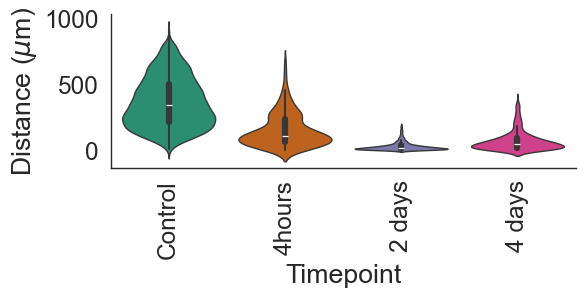

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

geojson_path = '../../annotations/SeqIF/sample_1d.r2.endocardium.geojson'
pixie_cell_dir = "../../../results/SeqIF/pixie_cell_masks_0.05/"
cell_table = pixie_cell_dir + "cell_table_size_normalized_cell_labels.csv"
pixie_cell_table = pd.read_csv(cell_table, header=0)
pixie_cell_table['fov'].unique()

# Generate a matching dictionary with keys from unique pixie_cell_table fov and values from unique sampleID
sampleID_dict = {"Control_13" : "sample_control.r1",
                "Control_12" : "sample_control.r2",
                "Control_14" : "sample_control.r3",
                "4h_96" : "sample_4h.r1",
                "4h_97" : "sample_4h.r2",
                "24h_83" : "sample_1d.r1",
                "24h_86" : "sample_1d.r2",
                "48h_76" : "sample_2d.r1",
                "48h_79" : "sample_2d.r2"}

# rename fovs based on the values for keys in sampleID_dict
pixie_cell_table['fov'] = pixie_cell_table['fov'].map(sampleID_dict)

# Create empty dictionary distance_dict
cells2 = ['Mono / Macros Ccr2+','Neutrophils']
distance_dict = {}
for sample in pixie_cell_table['fov'].unique(): 
    geojson_path = '../../annotations/SeqIF/' + sample + '.endocardium.geojson'
    distance_dict[sample] = calculate_distances(geojson_path = geojson_path,
                        pixie_cell_table = pixie_cell_table, 
                        sampleID = sample, 
                        cell_type_1 = "Endothelial cells",
                        cell_type_2 = cells2,
                        resolution = 0.23,
                        n_neighbours = 3)

import statsmodels.api as sm
from statsmodels.formula.api import ols
# # Plot a violin plot of the different groups in distance_dict
endo_distances_df = pd.DataFrame({'distance': np.concatenate(list(distance_dict.values())),
                                 'sample': np.concatenate([[key] * len(value) for key, value in distance_dict.items()])})

# Add a new column to endo_distances_df with the timepoint, based on the string between sample_ and .r in the sample column. Keep the string after sample_ and before .r
endo_distances_df['timepoint'] = endo_distances_df['sample'].str.extract(r'sample_(.*)\.r')
# Order timepoints in plots like this : Control, 4h, 1d, 2d
endo_distances_df['timepoint'] = pd.Categorical(endo_distances_df['timepoint'], categories=['control', '4h', '1d', '2d'], ordered=True)

my_pal = {"control": "#1B9E77", "4h": "#D95F02", "1d":"#7570B3", "2d":"#E7298A"}

# Use sm.stats.anova_lm to perform anova on endo_distances_df
aov_table = sm.stats.anova_lm(ols('distance ~ timepoint', data=endo_distances_df).fit(), typ=2)
print(aov_table)

import scikit_posthocs as sp
t_tests = sp.posthoc_ttest(endo_distances_df, val_col='distance', group_col='timepoint', p_adjust='bonferroni')
print(t_tests)

# # Set the order that the keys in endo_distances_dict will be plotted to control, 4h, 2d, 4d
# endo_distances_dict = {key: endo_distances_dict[key] for key in ['control', '2d', '4d']}

# sns.set_style('white')
# sns.set_context("paper", font_scale = 2)
# fig, ax = plt.subplots(figsize=(plot_size_factor*3,plot_size_factor))

# ax = sns.violinplot(data = endo_distances_df, x='key', y='value', palette=selected_colors,
#                alpha=1, linewidth=1)
# ax.set(xlabel=None)

# pairs = [("control", "2d"), ("control", "4d")]
# order = ['control', '2d', '4d']
# annot = Annotator(ax, pairs, data=endo_distances_df, x='key', y='value', order=order)
# annot.new_plot(ax, pairs= pairs,
#                data=endo_distances_df, x="key", y="value", order=order)
# annot.configure(loc='outside')
# annot.set_custom_annotations(["****", "****"])
# annot.annotate()


sns.set_style('white')
sns.set_context("paper", font_scale = 2)
# Set the plot size
plt.figure(figsize=(plot_size_factor*3,plot_size_factor))

sns.violinplot(x=endo_distances_df['timepoint'], y=endo_distances_df['distance'], 
               alpha=1, linewidth=1, palette=my_pal)

sns.despine()
plt.xlabel('Timepoint')
plt.ylabel('Distance (µm)')
plt.xticks([0, 1, 2,3], ['Control', '4hours', '2 days', '4 days'])

# Rotate x axis labels
plt.xticks(rotation=90)

plt.ylabel('Distance ($\mu$m)')
plt.savefig("../../output/seqIF/seqIF.endo_distances_ccr2.pdf", bbox_inches='tight')

# Calculate the mean and median distances per timepoint
print(endo_distances_df.groupby('timepoint')['distance'].agg(['mean', 'median']))

Text(0, 0.5, 'Number of cells')

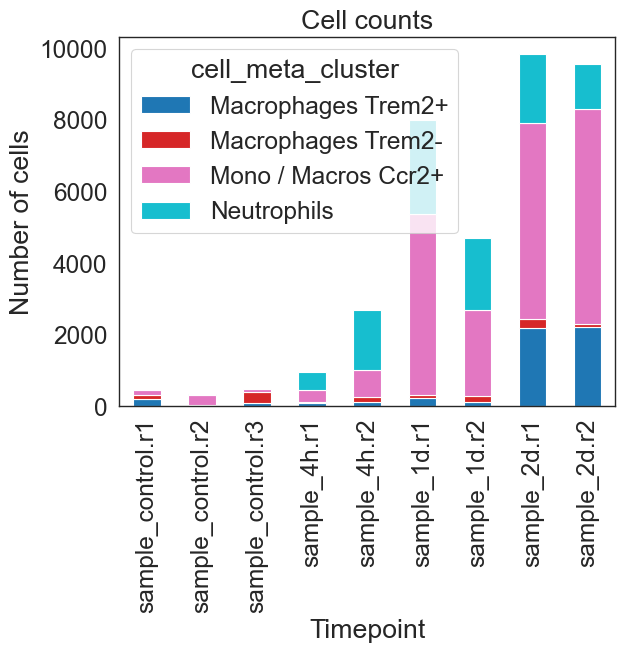

In [281]:
# Take pixie_cell_table group by fov and cell_meta_cluster and count the number of cells in each group
# Filter pixie cell table for cell_meta_cluster in 
pixie_cell_table_sub = pixie_cell_table[pixie_cell_table['cell_meta_cluster'].isin(['Mono / Macros Ccr2+', 'Neutrophils', 'Macrophages Trem2+', 'Macrophages Trem2-'])]
# Group by fov and cell_meta_cluster and count the number of cells in each group
cell_counts = pixie_cell_table_sub.groupby(['fov', 'cell_meta_cluster']).size().reset_index(name='counts')
cell_counts = cell_counts.pivot(index='fov', columns='cell_meta_cluster', values='counts')
cell_counts = cell_counts.fillna(0)
cell_counts = cell_counts.reset_index()
cell_counts['timepoint'] = cell_counts['fov'].str.extract(r'sample_(.*)\.r')
cell_counts['timepoint'] = pd.Categorical(cell_counts['timepoint'], categories=['control', '4h', '1d', '2d'], ordered=True)
cell_counts = cell_counts.sort_values(by='timepoint')
cell_counts = cell_counts.set_index('fov')
cell_counts = cell_counts.drop(columns=['timepoint'])
cell_counts.plot(kind='bar', stacked=True, colormap='tab10')
plt.title('Cell counts')
plt.xlabel('Timepoint')
plt.ylabel('Number of cells')
# Hide legend


## Calculate for subgroups

In [260]:
# From the code above, generate a function that takes as input a geojson file path, a cell table with cell annotations and two cell types of interest. It first subset the first cell type based on the geojson annotation and calculates the distances between the two cell types 
def calculate_distances_regions(geojson_path, pixie_cell_table, sampleID, cell_type_1, cell_type_2,resolution = 0.23, n_neighbours = 3):
    import geopandas as gpd
    import pandas as pd
    from shapely.geometry import Point
    from scipy.spatial import distance
    import numpy as np
    
    # Step 1: Read GeoJSON file
    polygons_gdf = gpd.read_file(geojson_path)

    # Filter polygons_gdf for classification name = subMI_endocardiallayer
    ## Check if sampleID contains 'control'
    if 'control' in sampleID:
        subset_rows = [polygons_gdf['classification'][i]['name'] == 'Endocardial_layer' for i in range(polygons_gdf.shape[0])]
        # Subset rows of polygons_gdf by subset_rows
        polygons_gdf_remote = polygons_gdf[subset_rows]
    else:
        subset_rows_infarct = [polygons_gdf['classification'][i]['name'] == 'subMI_endocardiallayer' for i in range(polygons_gdf.shape[0])]
        subset_rows_remote = [polygons_gdf['classification'][i]['name'] != 'subMI_endocardiallayer' for i in range(polygons_gdf.shape[0])]
        # Subset rows of polygons_gdf by subset_rows
        polygons_gdf_infarct = polygons_gdf[subset_rows_infarct]
        polygons_gdf_remote = polygons_gdf[subset_rows_remote]

    # Ensure that 'x' and 'y' columns exist
    if 'X_centroid' not in pixie_cell_table.columns or 'Y_centroid' not in pixie_cell_table.columns:
        raise ValueError("Table must contain 'x' and 'y' columns.")

    # Subset pixie_cell_table for fov == Control_12
    pixie_cell_table_sub = pixie_cell_table.loc[pixie_cell_table['fov'] == sampleID]

    sample_table = pixie_cell_table_sub[pixie_cell_table_sub['cell_meta_cluster'] != 'out_of_mask']

    cells1 = pixie_cell_table_sub[pixie_cell_table_sub['cell_meta_cluster'] == cell_type_1]

    # Subset sample table for only rows where column cell_meta_cluster is equal to 'Mono / Macros Ccr2+' or 'Neutrophils' or 'Macrophages Trem2+' or 'Macrophages Trem2-'
    cells2 = pixie_cell_table_sub[pixie_cell_table_sub['cell_meta_cluster'].isin(cell_type_2) ]

    # Step 3: Convert table to GeoDataFrame
    # Assuming the table has columns 'x' and 'y' for coordinates
    geometry = [Point(xy) for xy in zip(cells1.X_centroid, cells1.Y_centroid)]

    # Ensure that the 'geometry' column contains valid Shapely Geometry objects
    if not all(isinstance(geom, Point) for geom in geometry):
        raise ValueError("Invalid geometry objects in the 'geometry' column.")

    ## Turn pixie_cell_table into a geopandas dataframe
    points_gdf = gpd.GeoDataFrame(cells1, geometry=geometry)

    # Check and set CRS
    # Assuming your polygons_gdf has a defined CRS,
    # and your points should be in the same CRS
    if polygons_gdf_remote.crs is not None and points_gdf.crs is None:
        points_gdf.set_crs(polygons_gdf_remote.crs, inplace=True)

    # Step 4: Spatial join
    # Perform spatial join between points and polygons
    # This will add a column 'poly_id' to points_gdf
    # which contains the index of the polygon in polygons_gdf
        
    # invalidate this if statement "if 'control' in sampleID" 
    
    cells2_coords = cells2[['X_centroid', 'Y_centroid']].to_numpy()
    if 'control' in sampleID:
        # There are multiple polygons in polygons_gdf. Check overlap with all of them for each cell. Each cell can only be within one polygon at a time.
        points_gdf_remote = gpd.sjoin(points_gdf, polygons_gdf_remote, how="inner", op="within")
        
        # Step 5: Calculate distances
        ## Generate a numpy array with x and y coordinates from endocard_cells
        
        cells1_coords_remote = points_gdf_remote[['X_centroid', 'Y_centroid']].to_numpy()

        ## Step 5: Calculate distance between endocardial cells and myeloid cells
        cells_distances_remote = distance.cdist(cells1_coords_remote, cells2_coords, 'euclidean')

        # Transform the distances from pixel into micrometer by multiplying with the resolution of the image

        cells_distances_remote = cells_distances_remote * resolution

        # For each row in endo_distances, keep only the X smallest values and remove the other values from the array
        cells_distances_remote = np.array([np.sort(row)[:n_neighbours] for row in cells_distances_remote])

        # Flatten the array
        cells_distances_remote = cells_distances_remote.flatten()
        return {sampleID + "_remote" : cells_distances_remote}
    else:
        points_gdf_infarct = gpd.sjoin(points_gdf, polygons_gdf_infarct, how="inner", op="within")

        cells1_coords_infarct = points_gdf_infarct[['X_centroid', 'Y_centroid']].to_numpy()
        cells_distances_infarct = distance.cdist(cells1_coords_infarct, cells2_coords, 'euclidean')
        cells_distances_infarct = cells_distances_infarct * resolution
        cells_distances_infarct = np.array([np.sort(row)[:n_neighbours] for row in cells_distances_infarct])
        cells_distances_infarct = cells_distances_infarct.flatten()
        # There are multiple polygons in polygons_gdf. Check overlap with all of them for each cell. Each cell can only be within one polygon at a time.
        points_gdf_remote = gpd.sjoin(points_gdf, polygons_gdf_remote, how="inner", op="within")
        
        # Step 5: Calculate distances
        ## Generate a numpy array with x and y coordinates from endocard_cells
        cells1_coords_remote = points_gdf_remote[['X_centroid', 'Y_centroid']].to_numpy()
        cells2_coords = cells2[['X_centroid', 'Y_centroid']].to_numpy()

        ## Step 5: Calculate distance between endocardial cells and myeloid cells
        cells_distances_remote = distance.cdist(cells1_coords_remote, cells2_coords, 'euclidean')

        # Transform the distances from pixel into micrometer by multiplying with the resolution of the image

        cells_distances_remote = cells_distances_remote * resolution

        # For each row in endo_distances, keep only the X smallest values and remove the other values from the array
        cells_distances_remote = np.array([np.sort(row)[:n_neighbours] for row in cells_distances_remote])

        # return a dict with sampleID as key and cells_distances_infarct and cells_distances_remote as values
        return {sampleID + "_infarct": cells_distances_infarct, sampleID + "_remote": cells_distances_remote}


In [261]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

geojson_path = '../../annotations/SeqIF/sample_1d.r2.endocardium.geojson'
pixie_cell_dir = "../../../Lunaphore/pixie/masked_subset/cell_masks_0.05/"
cell_table = pixie_cell_dir + "cell_table_size_normalized_cell_labels.csv"
pixie_cell_table = pd.read_csv(cell_table, header=0)
pixie_cell_table['fov'].unique()

# Generate a matching dictionary with keys from unique pixie_cell_table fov and values from unique sampleID
sampleID_dict = {"Control_13" : "sample_control.r1",
                "Control_12" : "sample_control.r2",
                "Control_14" : "sample_control.r3",
                "4h_96" : "sample_4h.r1",
                "4h_97" : "sample_4h.r2",
                "24h_83" : "sample_1d.r1",
                "24h_86" : "sample_1d.r2",
                "48h_76" : "sample_2d.r1",
                "48h_79" : "sample_2d.r2"}

# rename fovs based on the values for keys in sampleID_dict
pixie_cell_table['fov'] = pixie_cell_table['fov'].map(sampleID_dict)

# Create empty dictionary distance_dict
distance_dict = {}
for sample in pixie_cell_table['fov'].unique(): 
    print(sample)
    geojson_path = '../../annotations/SeqIF/' + sample + '.endocardium.geojson'
    distance_dict[sample] = calculate_distances_regions(geojson_path = geojson_path,
                        pixie_cell_table = pixie_cell_table, 
                        sampleID = sample, 
                        cell_type_1 = "Endothelial cells",
                        cell_type_2 = ['Mono / Macros Ccr2+', 'Neutrophils', 'Macrophages Trem2+', 'Macrophages Trem2-'],
                        resolution = 0.23,
                        n_neighbours = 3)

sample_1d.r2


/Users/florian_wuennemann/miniconda3/envs/geopandas/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/florian_wuennemann/miniconda3/envs/geopandas/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


sample_1d.r1


/Users/florian_wuennemann/miniconda3/envs/geopandas/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/florian_wuennemann/miniconda3/envs/geopandas/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


sample_control.r1


/Users/florian_wuennemann/miniconda3/envs/geopandas/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


sample_control.r2


/Users/florian_wuennemann/miniconda3/envs/geopandas/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


sample_4h.r2


/Users/florian_wuennemann/miniconda3/envs/geopandas/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/florian_wuennemann/miniconda3/envs/geopandas/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/florian_wuennemann/miniconda3/envs/geopandas/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/florian_wuennemann/miniconda3/envs/geopandas/lib/python3.12/site-package

sample_4h.r1
sample_2d.r2


/Users/florian_wuennemann/miniconda3/envs/geopandas/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/florian_wuennemann/miniconda3/envs/geopandas/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


sample_2d.r1
sample_control.r3


/Users/florian_wuennemann/miniconda3/envs/geopandas/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/florian_wuennemann/miniconda3/envs/geopandas/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/florian_wuennemann/miniconda3/envs/geopandas/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


([0, 1, 2, 3],
 [Text(0, 0, 'control'), Text(1, 0, '4h'), Text(2, 0, '1d'), Text(3, 0, '2d')])

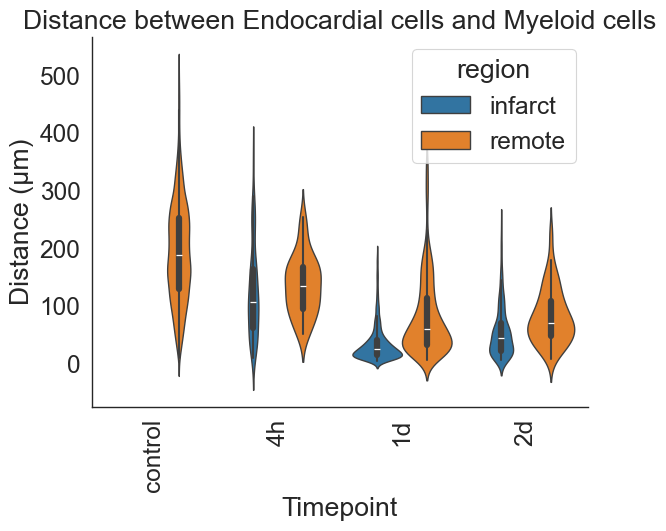

In [263]:
# Make an empty dataframe
endo_distances_df = pd.DataFrame()

for key, inner_dict in distance_dict.items():
    for inner_key, value in inner_dict.items():
        # Create a dataframe with a column distance and the values from the inner_dict. Values in inner dict are lists of 3 distances
        df = pd.DataFrame({'distance': value.flatten()})

        # Then, add a new column 'sample' that contains the inner_key for each row
        df['sample'] = inner_key

        # Append the inner_df to endo_distances_df
        endo_distances_df = pd.concat([endo_distances_df, df])

# Add a column named timepoint to endo_distances_df based on the string between sample_ and .r in the sample column. Keep the string after sample_ and before .r
endo_distances_df['timepoint'] = endo_distances_df['sample'].str.extract(r'sample_(.*)\.r')

# Sort timepoints in plots like this : Control, 4h, 1d, 2d
endo_distances_df['timepoint'] = pd.Categorical(endo_distances_df['timepoint'], categories=['control', '4h', '1d', '2d'], ordered=True)

# Add a colummn named region to endo_distances_df based on whether _remote or infarct is in the sample column. If _remote is in the sample column, the region is remote. If infarct is in the sample column, the region is infarct
endo_distances_df['region'] = np.where(endo_distances_df['sample'].str.contains('remote'), 'remote', 'infarct')

# Make a violin plot with timepoint on the x axis and distance on the y axis, and with the region as the hue
sns.set_style('white')
sns.set_context("paper", font_scale = 2)

sns.violinplot(x=endo_distances_df['timepoint'], y=endo_distances_df['distance'], hue=endo_distances_df['region'], alpha=1, linewidth=1, palette="tab10")
sns.despine()
plt.xlabel('Timepoint')
plt.ylabel('Distance (µm)')
plt.title('Distance between Endocardial cells and Myeloid cells')
# Rotate x axis labels
plt.xticks(rotation=90)

In [259]:
# Calculate mean and median distance for each sample by region and timepoint
print(endo_distances_df.groupby(['timepoint', 'region'])['distance'].agg(['mean', 'median']))

                         mean      median
timepoint region                         
control   infarct         NaN         NaN
          remote   192.917397  187.962434
4h        infarct  124.587629  105.748741
          remote   136.358329  133.809530
1d        infarct   34.382474   23.998157
          remote    81.115506   58.970338
2d        infarct   54.930767   44.805129
          remote    81.992916   69.380099


/var/folders/ph/m6mhj3s541799cykzbp3dx0m0000gn/T/ipykernel_37806/2576309867.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(endo_distances_df.groupby(['timepoint', 'region'])['distance'].agg(['mean', 'median']))
